# Machine Learning
Yorick Juffer - s1993623 \
Leon Koole - s4436563 \
... \
Alejandro Sánchez Roncero - s5279402

## Libraries

In [308]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix 

%config InlineBackend.figure_format = 'retina'

# Loading data
This dataset contains 2000 grayscale images of handwritten digits, 200 from each class. The images are 15 × 16 
sized, making for n = 240 dimensional image vectors. The data are in the attached text file mfeat-pix.txt, 
one vector per row, sorted such that the first 200 rows are "0" digit examples, the next 200 are "1" digit examples 
etc. The grayscale encoding in mfeat-pix.txt is done by integer steps from 0 (white) to 6 (black). 

In [309]:
# Load lines from mfeat-pix.txt
features = open('mfeat-pix.txt').readlines()

# Create labels for each line, 0-9 for each 200 lines
labels = []
for i in range(10):
  for j in range(200):
    labels.append(i)
labels = np.array(labels)

# Convert each line to a numpy array
for i in range(len(features)):
  features[i] = np.array(features[i].split()).astype('float').reshape(16, 15, 1)
  # Normalize
  features[i] = features[i] / 6
features = np.array(features)


# Plot stuff

6


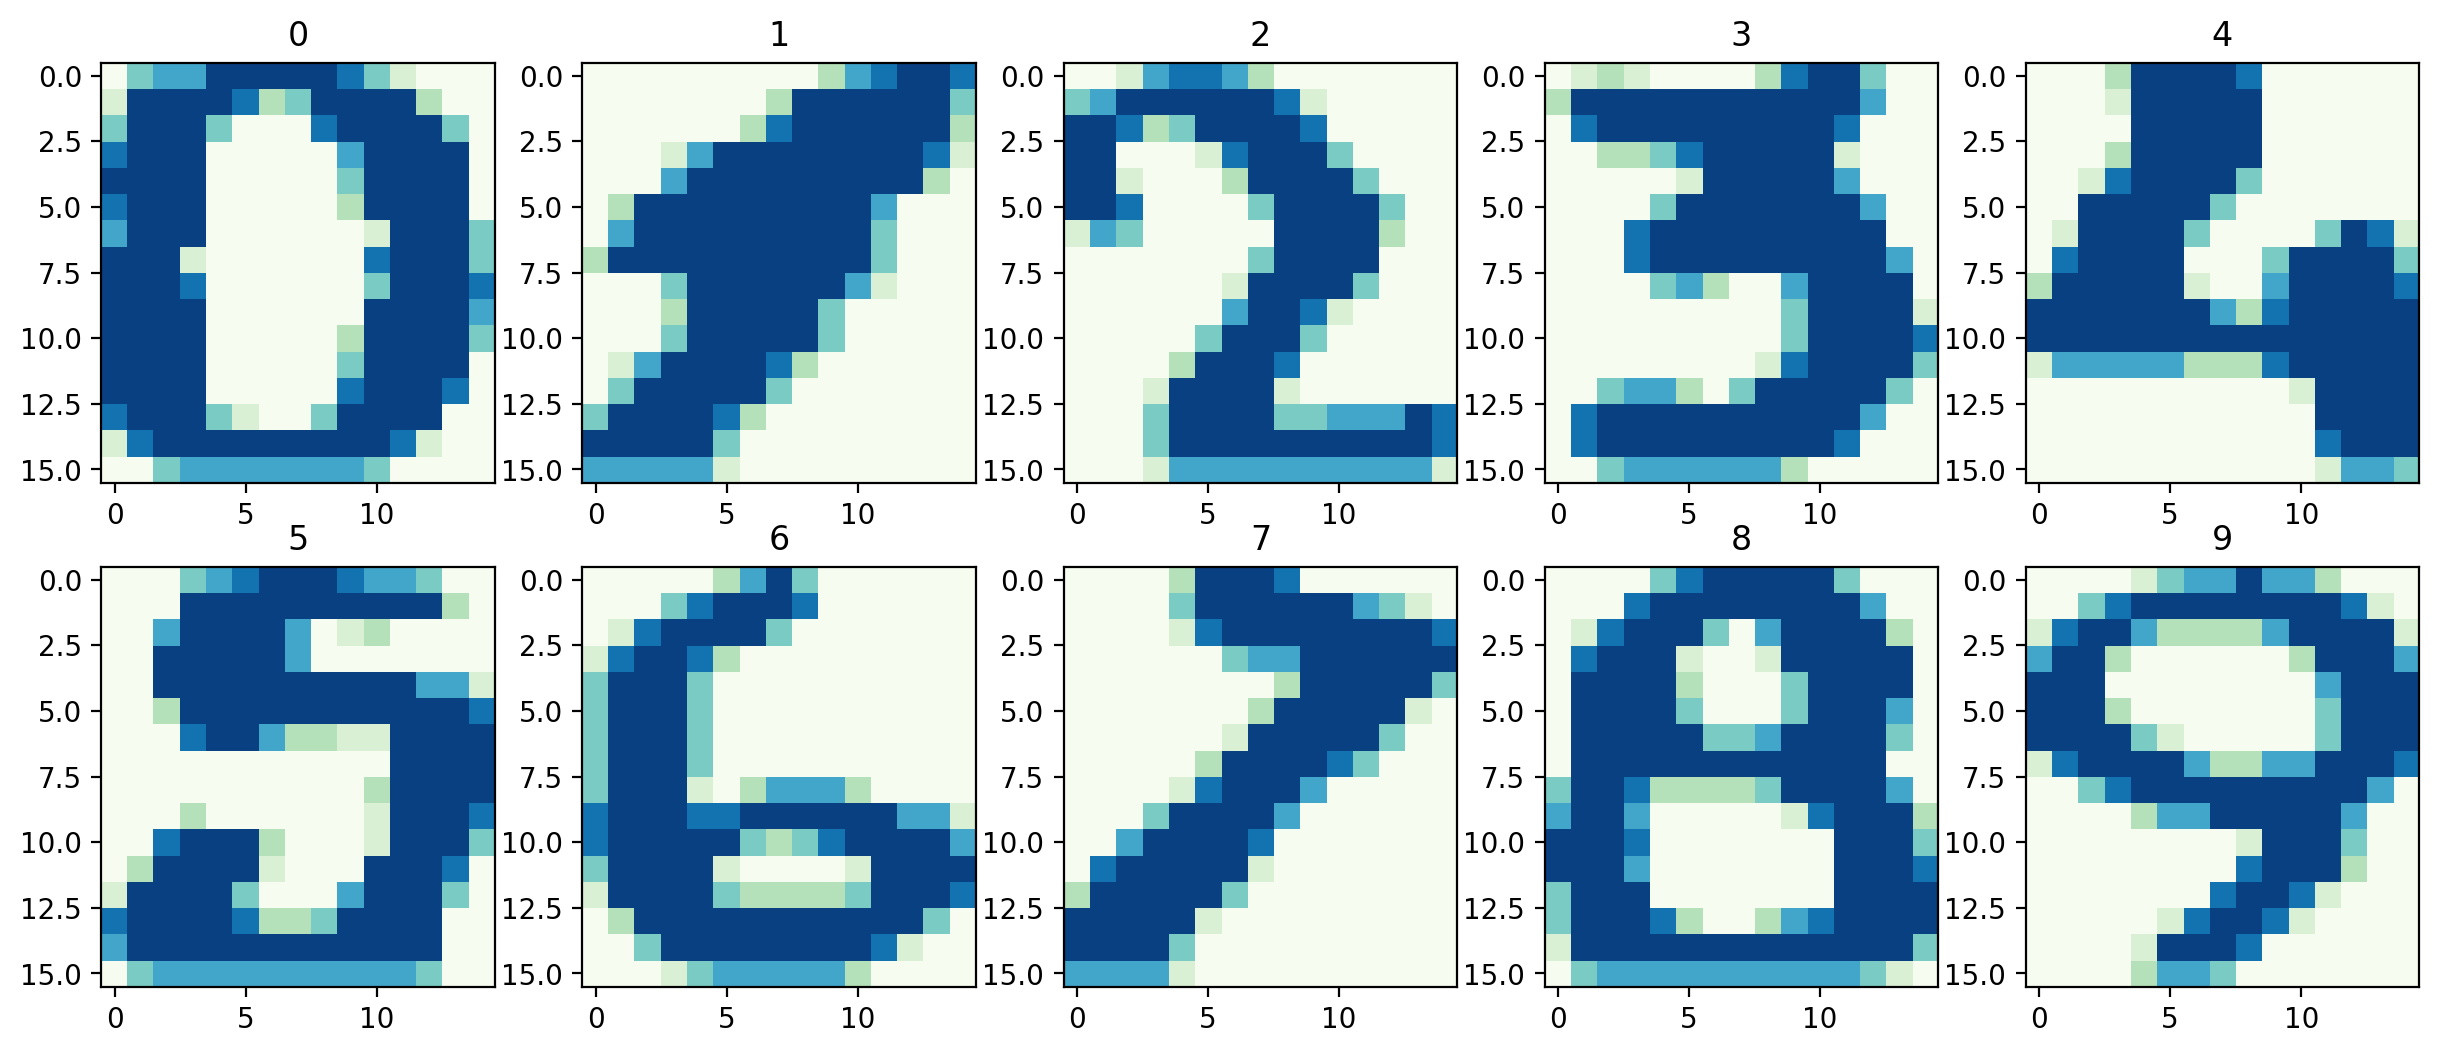

In [310]:
print(labels[1200])

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
  for j in range(5):
    axs[i, j].imshow(features[(5*i+j)*200], cmap='GnBu', interpolation='nearest')
    axs[i, j].set_title(labels[(5*i+j)*200])


## Split

In [311]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=40)

# Data augmentation

In [312]:
# Define image generator for data augmentation
image_generator = ImageDataGenerator(
    rotation_range=20,
    zoom_range=[1, 0.9],
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=20,
    fill_mode="constant",
    cval=0
)
image_generator.fit(X_train.reshape(X_train.shape[0], 16, 15, 1))


BEFORE:



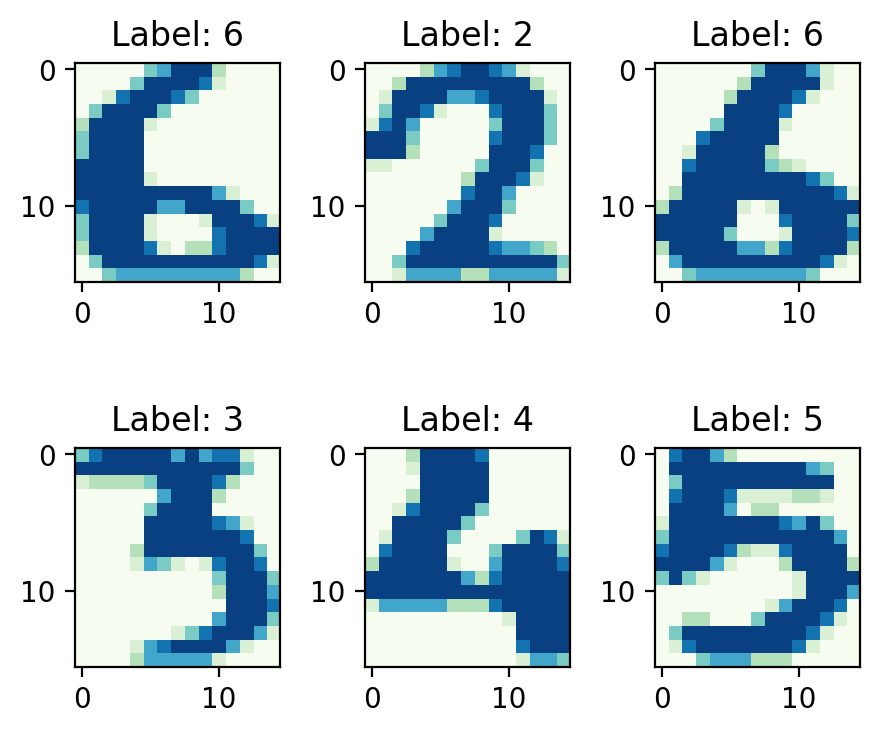

AFTER:



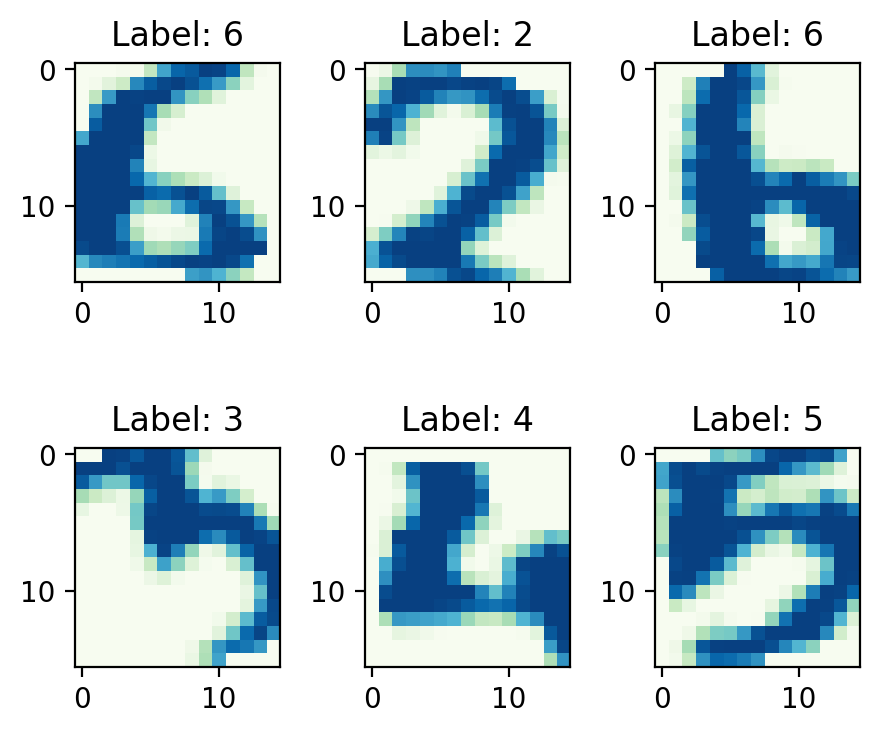

In [313]:
# define number of rows & columns
num_row = 2
num_col = 3
num = num_row * num_col
# plot before
print("BEFORE:\n")
# plot images
fig1, axes1 = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
for i in range(num):
    ax = axes1[i // num_col, i % num_col]
    ax.imshow(X_train[i], cmap="GnBu")
    ax.set_title("Label: {}".format(y_train[i]))
plt.tight_layout()
plt.show()

# plot after
print("AFTER:\n")
fig2, axes2 = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
for X, Y in image_generator.flow(
    X_train.reshape(X_train.shape[0], 16, 15, 1),
    y_train.reshape(y_train.shape[0], 1),
    batch_size=num,
    shuffle=False,
):
    for i in range(0, num):
        ax = axes2[i // num_col, i % num_col]
        ax.imshow(X[i].reshape(16, 15), cmap="GnBu")
        ax.set_title("Label: {}".format(int(Y[i])))
    break
plt.tight_layout()
plt.show()

In [314]:
X_train_augmented = []
y_train_augmented = []
for X, Y in image_generator.flow(
    X_train.reshape(X_train.shape[0], 16, 15, 1),
    y_train,
    batch_size=1000,
    shuffle=False,
):
    for i in range(5):
        for j in range(1000):
            X_train_augmented.append(X[j].reshape(16, 15))
            y_train_augmented.append(int(Y[j]))
    break

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

# Add original data to augmented data
X_train_augmented = np.concatenate((X_train_augmented.reshape(X_train_augmented.shape[0], 16, 15, 1), X_train))
y_train_augmented = np.concatenate((y_train_augmented, y_train))

print(X_train_augmented.shape)
print(y_train_augmented.shape)

(6600, 16, 15, 1)
(6600,)


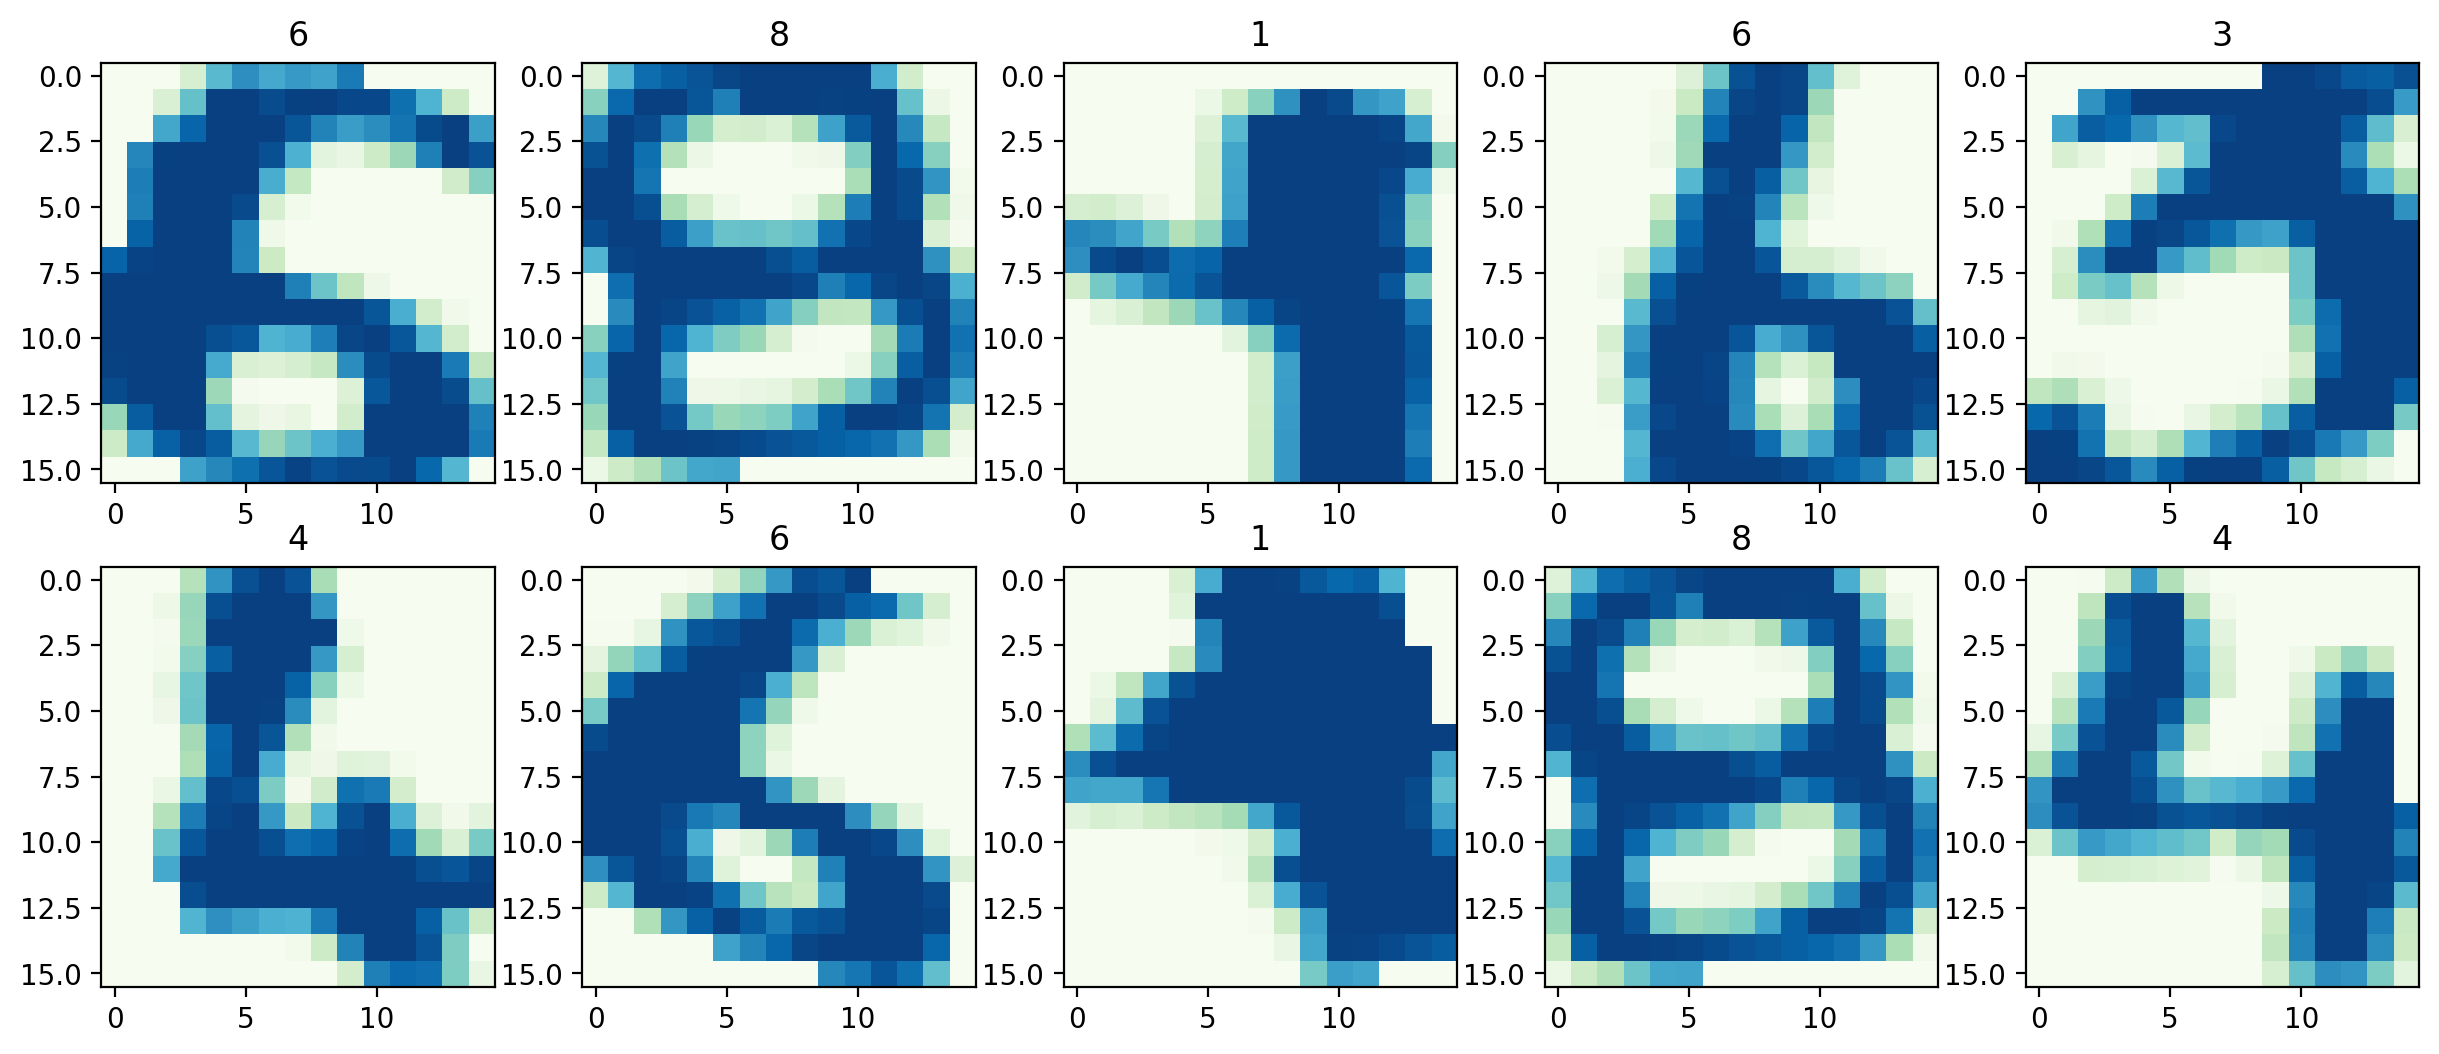

In [315]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
  for j in range(5):
    # Get random index from 0 to 20000
    index = np.random.randint(0, 1000)
    axs[i, j].imshow(X_train_augmented[index], cmap='GnBu', interpolation='nearest')
    axs[i, j].set_title(y_train_augmented[index])

# CNN Model

In [335]:
model = keras.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(16, 15, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation="softmax"))

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

model_augmented = tf.keras.models.clone_model(model)

model_augmented.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)


In [317]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 14, 13, 32)        320       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 7, 6, 32)         0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 1344)              0         
                                                                 
 dense_30 (Dense)            (None, 128)               172160    
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 10)                1290      
                                                     

## Compile and train

In [318]:
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))

Epoch 1/25


/usr/local/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


50/50 [==============================] - 1s 9ms/step - loss: 1.5914 - accuracy: 0.4856 - val_loss: 0.7084 - val_accuracy: 0.8800
Epoch 2/25
50/50 [==============================] - 0s 5ms/step - loss: 0.6430 - accuracy: 0.8062 - val_loss: 0.3008 - val_accuracy: 0.9300
Epoch 3/25
50/50 [==============================] - 0s 6ms/step - loss: 0.4094 - accuracy: 0.8869 - val_loss: 0.2284 - val_accuracy: 0.9325
Epoch 4/25
50/50 [==============================] - 0s 6ms/step - loss: 0.3066 - accuracy: 0.9150 - val_loss: 0.1760 - val_accuracy: 0.9500
Epoch 5/25
50/50 [==============================] - 0s 6ms/step - loss: 0.2568 - accuracy: 0.9319 - val_loss: 0.1471 - val_accuracy: 0.9600
Epoch 6/25
50/50 [==============================] - 0s 6ms/step - loss: 0.2107 - accuracy: 0.9506 - val_loss: 0.1182 - val_accuracy: 0.9650
Epoch 7/25
50/50 [==============================] - 0s 6ms/step - loss: 0.1859 - accuracy: 0.9488 - val_loss: 0.1318 - val_accuracy: 0.9600
Epoch 8/25
50/50 [=============

### Evaluate model

In [319]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

13/13 - 0s - loss: 0.0981 - accuracy: 0.9800 - 38ms/epoch - 3ms/step


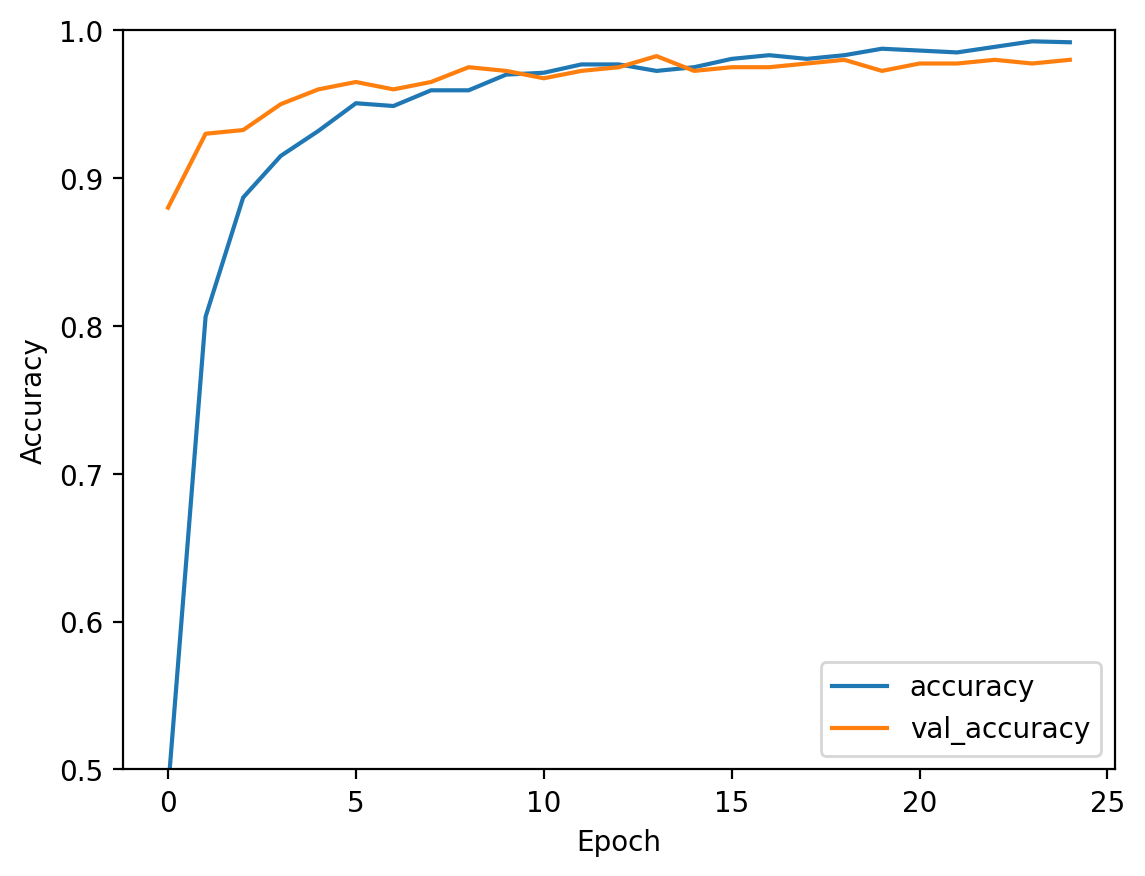

In [320]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

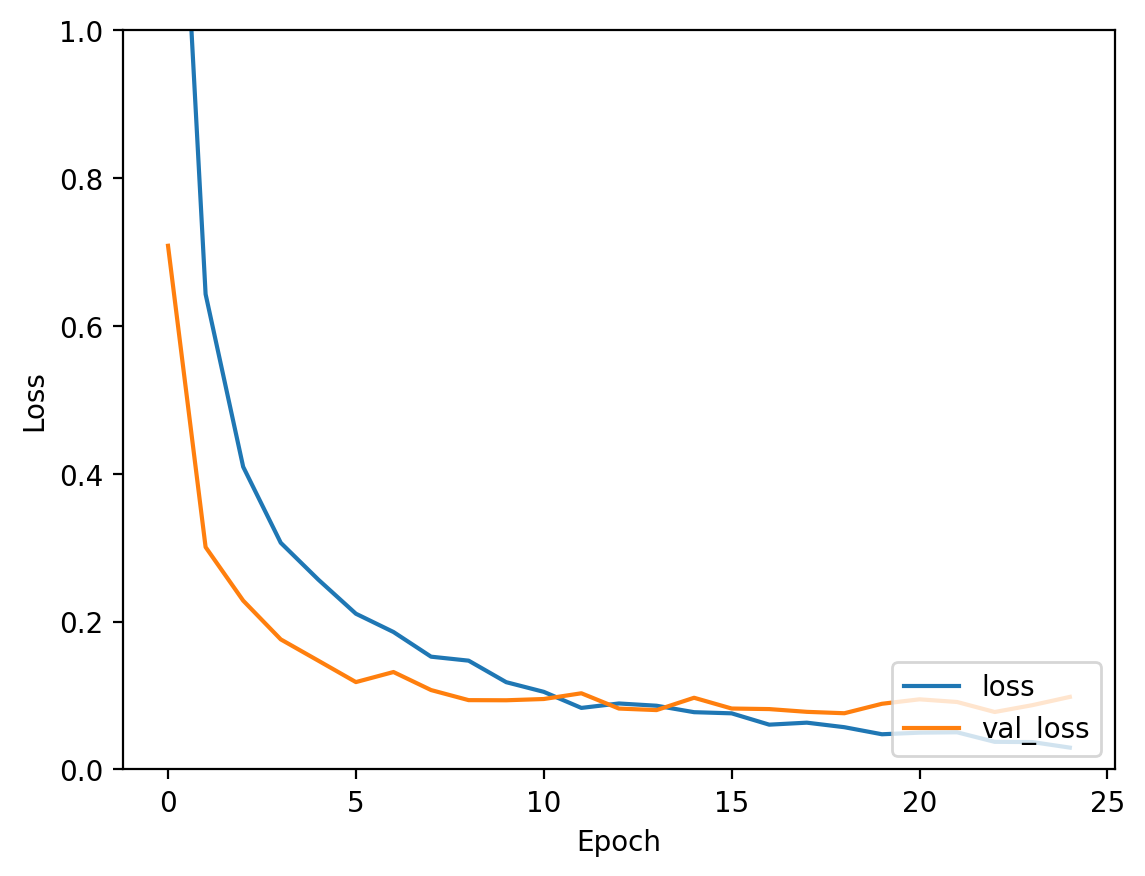

In [321]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

# Train augmented

In [336]:
history_augmented = model_augmented.fit(X_train_augmented.reshape(X_train_augmented.shape[0], 16, 15, 1), y_train_augmented, batch_size=100, epochs=25, shuffle=True, validation_data=(X_test, y_test))

Epoch 1/25
66/66 [==============================] - 1s 11ms/step - loss: 1.2504 - accuracy: 0.6205 - val_loss: 0.3094 - val_accuracy: 0.9300
Epoch 2/25
66/66 [==============================] - 1s 9ms/step - loss: 0.5007 - accuracy: 0.8536 - val_loss: 0.1827 - val_accuracy: 0.9450
Epoch 3/25
66/66 [==============================] - 1s 9ms/step - loss: 0.3443 - accuracy: 0.9009 - val_loss: 0.1351 - val_accuracy: 0.9625
Epoch 4/25
66/66 [==============================] - 1s 11ms/step - loss: 0.2614 - accuracy: 0.9235 - val_loss: 0.1116 - val_accuracy: 0.9650
Epoch 5/25
66/66 [==============================] - 1s 10ms/step - loss: 0.1978 - accuracy: 0.9435 - val_loss: 0.0929 - val_accuracy: 0.9675
Epoch 6/25
66/66 [==============================] - 1s 11ms/step - loss: 0.1533 - accuracy: 0.9545 - val_loss: 0.0765 - val_accuracy: 0.9800
Epoch 7/25
66/66 [==============================] - 1s 8ms/step - loss: 0.1344 - accuracy: 0.9617 - val_loss: 0.0695 - val_accuracy: 0.9825
Epoch 8/25
66/66

In [337]:
test_loss_augmented, test_acc_augmented = model_augmented.evaluate(X_test,  y_test, verbose=2)

13/13 - 0s - loss: 0.0727 - accuracy: 0.9800 - 200ms/epoch - 15ms/step


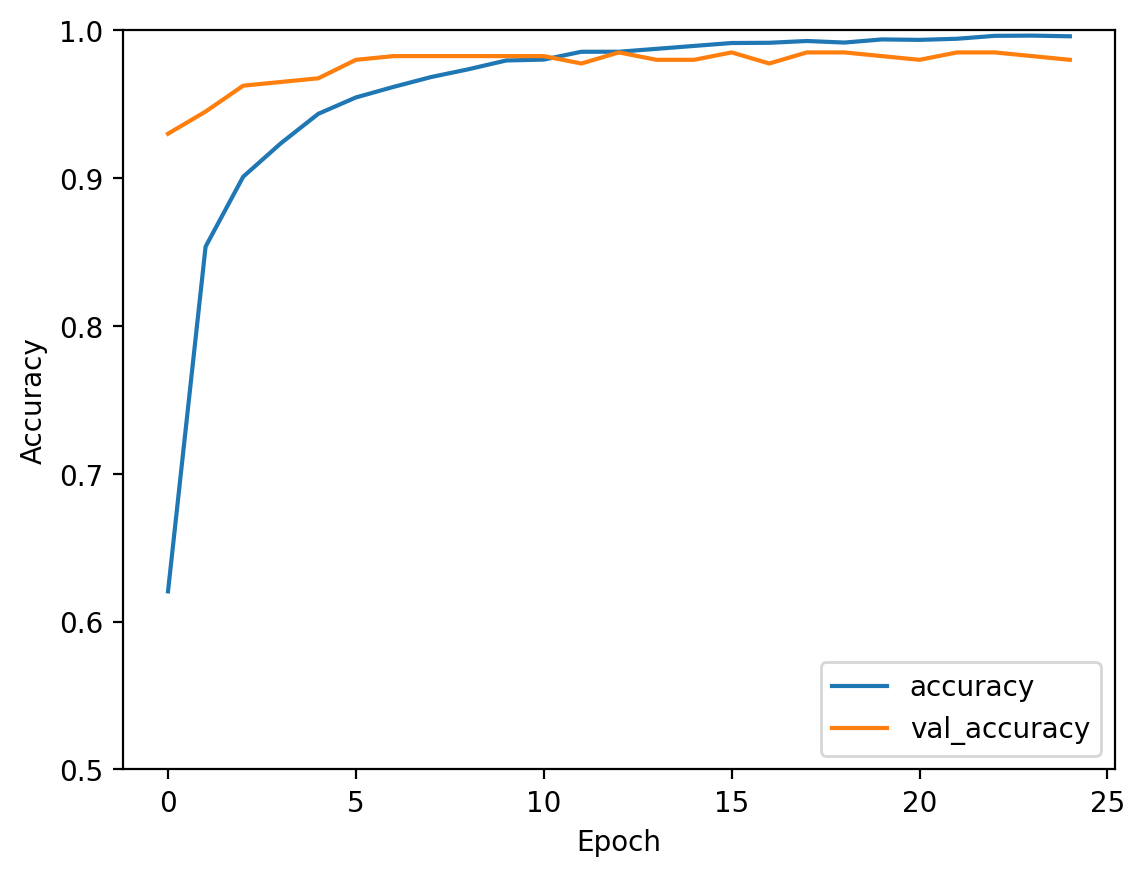

In [338]:
plt.plot(history_augmented.history['accuracy'], label='accuracy')
plt.plot(history_augmented.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

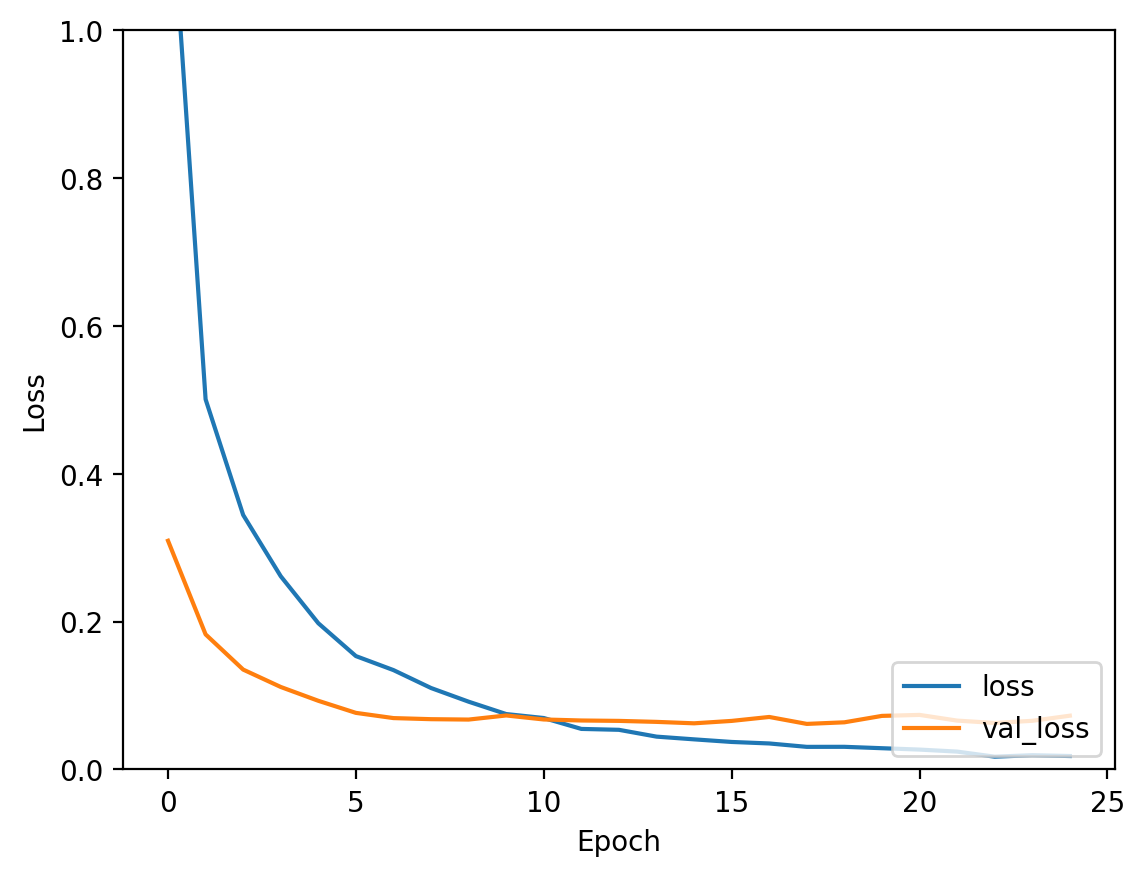

In [339]:
plt.plot(history_augmented.history['loss'], label='loss')
plt.plot(history_augmented.history['val_loss'], label = 'val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')